# Imports

In [26]:
import os
import copy
import math
import csv
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

np.random.seed(0)
np.seterr(divide = 'ignore') 
plt.style.use('seaborn-paper')

# Dataset

## Loading dataset

In [3]:
!gdown 11qXv2vipvTPVVKyB2x_otsl1s3sSvonk
!unzip -o data.zip -d data

Downloading...
From: https://drive.google.com/uc?id=11qXv2vipvTPVVKyB2x_otsl1s3sSvonk
To: /content/data.zip
100% 18.5k/18.5k [00:00<00:00, 9.00MB/s]
Archive:  data.zip
  inflating: data/Contextual_data.xlsx  
   creating: data/samples/
  inflating: data/samples/sample_1.csv  
  inflating: data/samples/sample_11.csv  
  inflating: data/samples/sample_12.csv  
  inflating: data/samples/sample_13.csv  
  inflating: data/samples/sample_14.csv  
  inflating: data/samples/sample_15.csv  
  inflating: data/samples/sample_16.csv  
  inflating: data/samples/sample_18.csv  
  inflating: data/samples/sample_19.csv  
  inflating: data/samples/sample_2.csv  
  inflating: data/samples/sample_20.csv  
  inflating: data/samples/sample_21.csv  
  inflating: data/samples/sample_23.csv  
  inflating: data/samples/sample_24.csv  
  inflating: data/samples/sample_25.csv  
  inflating: data/samples/sample_3.csv  
  inflating: data/samples/sample_4.csv  
  inflating: data/samples/sample_5.csv  
  inflating: 

In [4]:
excel_data = pd.read_excel('data/Contextual_data.xlsx',engine='openpyxl')

Y = list()
for _id in excel_data['sample no.']:
    sample_path = 'data/samples/sample_{}.csv'.format(_id)
    if os.path.exists(sample_path):
        Y.append(pd.read_csv(sample_path))

In [5]:
Y_train, Y_test = train_test_split(Y, test_size=1, random_state=42)

# Utils

In [6]:
def log(x):
    if x < 0:
        raise ValueError('Negative value encoutered', x)
    elif x == 0:
        return -np.inf
    else:
        return np.log(x)

In [7]:
def exp(x):
    if x == -np.inf:
        return 0
    elif x == np.inf:
        raise ValueError('Positive infinity in epx')
    else:
        return np.exp(x)

In [8]:
def log_sum(ln_x, ln_y):
    # implementation based on Algorithm 3 of link http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf
    if ln_x == -np.inf or ln_y == -np.inf:
        # Note: if both ln_x and ln_y were -inf we inevitably return -inf
        if ln_x == -np.inf:
            return ln_y
        else:
            return ln_x 
    else:
        if ln_x > ln_y:
            return ln_x + log(1 + exp(ln_y - ln_x))
        else:
            return ln_y + log(1 + exp(ln_x - ln_y))

In [9]:
def log_product(ln_x, ln_y):
    # implementation based on Algorithm 4 of link http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf
    if ln_x == -np.inf or ln_y == -np.inf:
        return -np.inf
    else:
        return ln_x + ln_y

## Checking sample lengths

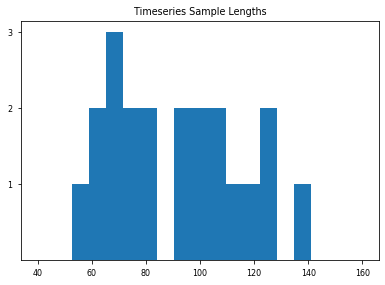

In [10]:
lengths = []
for y in Y:
    lengths.append(len(y))

plt.hist(lengths, np.linspace(40, 160, 20))
plt.yticks([1,2,3])
plt.title('Timeseries Sample Lengths')
plt.show()

## Cleaning data

In [11]:
def clean_batch(batch):

    def _clean_sample(sample):
        out = sample.copy()

        out.drop('Unnamed: 0', axis=1, inplace=True)

        for col in out.columns:
            out[col].fillna(out[col].mode()[0], inplace=True)
        
        out = out[['f1', 'f2', 'f3', 'f4', 'f5', 'target']]
        out = out[(out.target==1)|(out.target==2)]
        out.reset_index(drop=True, inplace=True)

        out.target -= 1 # so can be used as index

        return out

    cleaned_batch = list()
    for sample in batch:
        cleaned_batch.append(_clean_sample(sample))
    return cleaned_batch

# Constants

In [12]:
STATE = [0, 1]
FEATURE = [0, 1, 2, 3, 4]
NUMBER_STATE = 2
TIME_SERIES_LENGTH = 160
SMALL_VALUE = 1e-9

# Hidden Markov Models

## Sum-product

### $\alpha$, $\beta$ recursions

Implement the $\alpha$ and $\beta$-recursions.

Recall that $\alpha(x_t) := p(x_t, y_{1:t})$, $\beta(x_t) := p(y_{(t+1):T} | x_t)$. Implement also a function to compute the emission probabilties $\epsilon_k(y_t) := p(y_t|x_t=k)$.

For numerical stability reasons, you can implement your algorithms using **log probabilities**!



In [13]:
def comp_transition(Y):
    # Note: Y is BATCH of time series samples

    # initialization
    M = np.zeros((NUMBER_STATE, NUMBER_STATE))

    # frequency count
    for y in Y:
        pst = y.target[0]
        for st in y.target[1:]:
            M[pst-1, st-1] += 1
            pst = st
    
    # normalization
    for st in STATE:
        total_freq = sum(cnt for cnt in M[st]) + 1e-9 # add with small number to avoid Division by zero
        M[st] = np.array([cnt/total_freq for cnt in M[st]])
    
    return M

def emission_prob(eps, state, obs):
    prob = 1
    # obs_plus_epsilon = np.array(obs) + 0.01
    # obs_minus_epsilon = np.array(obs) - 0.01
    for fi in FEATURE:
        prob *= (eps[state][fi].cdf(obs[fi] + 0.01) - eps[state][fi].cdf(obs[fi] - 0.01))
    return prob

def emission(Y):
    # Note: Y is a BATCH of time series samples

    eps = dict()
    for st in STATE:
        eps[st] = dict()
        for fi in FEATURE:
            eps[st][fi] = dict()


    # calculate probability
    for st in STATE:
        for fi in FEATURE:
            arr = list()
            for y in Y:
                for _, ins in y.iterrows():
                    *obs, state = ins
                    if st == state:
                        arr.append(np.array(obs[fi]))
            arr = np.array(arr)
            mean = np.mean(arr, axis=0)
            var = np.cov(arr.T)
            eps[st][fi]= multivariate_normal(mean, var)

    return eps

def alpha_recursion(Y, M, eps, pi):
    # Note: Y is SINGLE time series sample
    # implemented based on Algorithm 5
    # Solution for numerical issues are based on https://courses.engr.illinois.edu/ece417/fa2020/slides/lec14.pdf

    # initialization step
    log_alpha = np.zeros((TIME_SERIES_LENGTH, NUMBER_STATE))
    for st in STATE:
        *obs, _ = Y.iloc[0]
        log_alpha[0, st] = log_product(log(pi[st]), log(emission_prob(eps, st, obs)))

    # recursion step
    for t, vars in Y.iloc[1:].iterrows():
        *obs, _ = vars
        for stj in STATE:
            log_a = -np.inf
            for sti in STATE:
                log_a = log_sum(log_a, log_product(log_alpha[t-1, sti], log(M[sti][stj])))
            log_alpha[t, stj] = log_product(log_a, log(emission_prob(eps, stj, obs)))

    return log_alpha

def beta_recursion(Y, M, eps) :
    # Note: Y is SINGLE time series sample
    # Implementation is based on Algorithm 6

    # initialization step
    T = len(Y)
    log_beta = np.zeros((TIME_SERIES_LENGTH, NUMBER_STATE))
    for st in STATE:
        log_beta[T-1, st] = 0

    # recursion step
    for t in reversed(range(T-1)):
        *nobs, _ = Y.iloc[t+1]
        for sti in STATE:
            log_b = -np.inf
            for stj in STATE:
                log_b = log_sum(log_b, 
                                log_product(log(M[sti][stj]),
                                            log_product(emission_prob(eps, stj, nobs),
                                                        log_beta[t+1, stj])
                                            )
                                )
            log_beta[t, sti] = log_b
    return log_beta

Using the two functions above, implement the computation of the *smoothing* distribution $p(x_t|y_1,\dots,y_T)$ and pair-marginals $p(x_t,x_{t+1}|y_1,\dots,y_T)$. Here use log probabilities from the $\alpha$ and $\beta$, but return a normal (not log!) probability, i.e, a number in $[0,1]$.

In [14]:
def smoothing(log_alpha, log_beta):
    T, K = alpha.shape

    log_gamma = np.zeros((T, K))
    for t in range(T):
        normalizer = -np.inf
        for st in STATE:
            log_gamma[t, st] = log_product(log_alpha[t,st], log_beta[t,st])
            normalizer = log_sum(normalizer, log_gamma[t, st])

        for st in STATE:
            log_gamma[t, st] = log_product(log_gamma[t,st], -normalizer)

    return log_gamma

def pair_marginals(Y, log_alpha, log_beta, M, eps):
    T, K = alpha.shape

    log_psi = np.zeros((T, K, K))
    for t in range(len(Y) - 1):
        *nobs, _ = Y.iloc[t+1]
        normalizer = -np.inf
        for sti in STATE:
            for stj in STATE:
                log_psi[t, sti, stj] = log_product(log_alpha[t, sti], 
                                                   log_product(log(M[sti, stj]),
                                                               log_product(log(emission_prob(eps, stj, nobs)),
                                                                           log_beta[t+1, stj]
                                                                           )
                                                               )
                                                   )
                normalizer = log_sum(normalizer, log_psi[t, sti, stj])

        for sti in STATE:
            for stj in STATE:
                log_psi[t, sti, stj] = log_product(log_psi[t, sti, stj], -normalizer)

    return log_psi

Let $\{y_1,\dots,y_T\}$ be the **test** data. Using your functions above, for all $t$ on the test data, compute $\alpha_t$, $\beta_t$ and  $p(x_t | y_1,\dots,y_T)$. Finally, plot $p(x_t|y_1,\dots,y_T)$ for each of the 2 states as a function of $t$ for one sample. 

In [15]:
def plot_smoothing(gamma, K=2, time_limit=160):
    plt.figure(figsize=(14, 2*K))
    plt.suptitle('Smoothing probabilities $p(z_t|x_1, ..., x_T)$', fontsize=16)
    for k in range(K):
        plt.subplot(K, 1, 1+k)
        plt.plot(range(1, time_limit+1), np.exp(gamma[:time_limit, k]))
        plt.ylabel(r'$p(z_t = ' + str(k+1) + ' | x_{1:T})$')
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

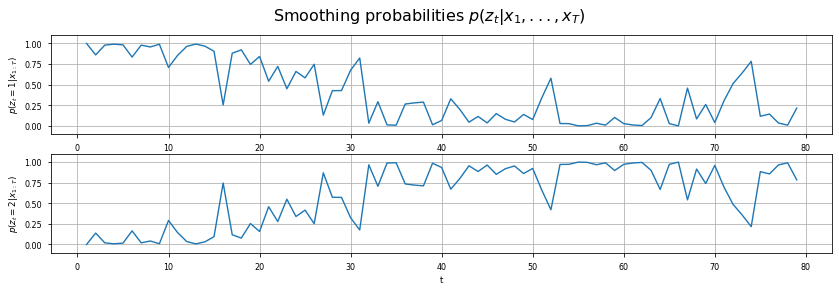

In [16]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
Yc_train, Yc_test = clean_batch(Y_train), clean_batch(Y_test)
eps = emission(Yc_train)
M = comp_transition(Yc_train)
pi = np.array([1, 1e-9])

# Perform (log) alpha and beta recursions
alpha = alpha_recursion(Yc_test[0], M, eps, pi)
beta = beta_recursion(Yc_test[0], M, eps)

# Compute smoothing probabilities
gamma = smoothing(alpha, beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma, time_limit=Yc_test[0].shape[0])

## Viterbi 

Implement Viterbi decoding.

In [17]:
def viterbi(Y, pi, M, eps):
    # initialization step
    vit = np.zeros((NUMBER_STATE, TIME_SERIES_LENGTH))
    backpointer = np.zeros((NUMBER_STATE, TIME_SERIES_LENGTH))
    for st in STATE:
        *obs, _ = Y.iloc[0]
        vit[st, 0] = log_product(log(pi[st]), log(emission_prob(eps, st, obs)))
        backpointer[st, 0] = None

    # recursion step
    for t, vars in Y.iloc[1:].iterrows():
        *obs, _ = vars
        for st in STATE:
            _c = [log_product(vit[pst, t-1], 
                              log_product(log(M[pst][st]), 
                                          log(emission_prob(eps, st, obs)))) for pst in STATE]
            vit[st, t] = max(_c)
            backpointer[st, t] = np.argmax(_c)
    
    # termination step
    best_path_prob = max(vit[:, t])
    best_state_ptr = np.argmax(vit[:, t])

    best_path = []
    while not math.isnan(best_state_ptr):
        best_state_ptr = int(best_state_ptr)
        best_path.append(best_state_ptr)
        best_state_ptr = backpointer[best_state_ptr, t]
        t -= 1
    best_path.reverse()

    return best_path, best_path_prob

Using the set of parameters learned with the EM algorithm on the **training** set, compute the most likely sequence of states for the **training** data with the Viterbi algorithm. Plot your results.

In [18]:
def plot_viterbi(predicted_path, expected_path):
    plt.figure(figsize=(28, 4))
    plt.suptitle('Predict Hidden State via Viterbi', fontsize=16)
    for i, ins in enumerate({'predicted': predicted_path, 'expected': expected_path}.items()):
        plt.subplot(2, 1, 1+i)
        plt.plot(ins[1], marker='o')
        plt.xticks(list(range(len(ins[1]))))
        plt.yticks(STATE)
        plt.ylim(-0.1, 1.1)
        plt.ylabel(ins[0])
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

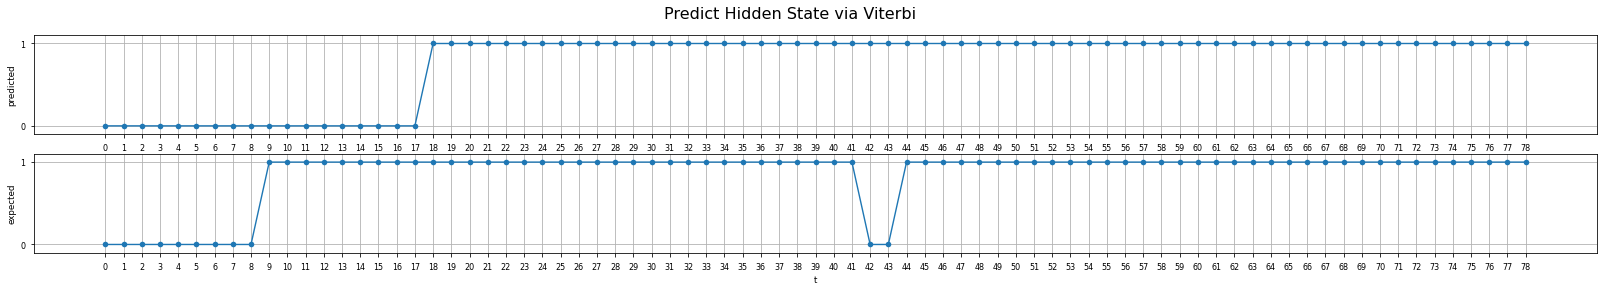

In [19]:
# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
Yc_test = clean_batch(Y_test)
best_path, best_path_prob = viterbi(Yc_test[0], pi, M, eps)

plot_viterbi(predicted_path=best_path, expected_path=Yc_test[0].target.tolist())

# Training

In [ ]:
from itertools import combinations

pi = np.array([1, 1e-9])
Yc = clean_batch(Y)

for length in range(1, 6):
    FEATUREs = combinations([0, 1, 2, 3, 4], length)
    for FEATURE in FEATUREs:
        overal_acc = 0
        for i in tqdm(range(len(Yc))):
            yc_test = Yc[i]
            Yc_train = [Yc[j] for j in range(len(Yc)) if j!=i]

            eps = emission(Yc_train)
            M = comp_transition(Yc_train)


            best_path, _ = viterbi(yc_test, pi, M, eps)
            overal_acc += accuracy_score(y_true=yc_test.target.tolist(), y_pred=best_path) / len(Yc) 

        print("Overal Accuracy: {} with features {}".format(overal_acc, FEATURE))

  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7191679344960216 with features (0,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4016951786083211 with features (1,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5987607900453146 with features (2,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6616234106136064 with features (3,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4817205834928477 with features (4,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7357797848245371 with features (0, 1)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7332112449389963 with features (0, 2)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7404489995328201 with features (0, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.644628322014564 with features (0, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6656753741573913 with features (1, 2)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.629212356801769 with features (1, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.480120758290538 with features (1, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6262848572610955 with features (2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6223960602251499 with features (2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6107687718578657 with features (3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7241967506104887 with features (0, 1, 2)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.756717448560396 with features (0, 1, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6223573177643122 with features (0, 1, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.732520686504833 with features (0, 2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6803476296240722 with features (0, 2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6958336461330925 with features (0, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6310292460438895 with features (1, 2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6090336671866818 with features (1, 2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5950258258108987 with features (1, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6653810538327881 with features (2, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7220309646661586 with features (0, 1, 2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6734505175023514 with features (0, 1, 2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6748532213551994 with features (0, 1, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.691582414828495 with features (0, 2, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.665130611978655 with features (1, 2, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6845949942334792 with features (0, 1, 2, 3, 4)


# Test

Initializing constants with best results

In [20]:
FEATURE = [0, 1, 3]

Cleaning train samples

In [21]:
Y_train_idx = list(range(len(Y)))
Y_train = Y

Yc_train = clean_batch(Y_train)

Calculate $\epsilon$ and transition matrix.

In [23]:
eps = emission(Yc_train)
M = comp_transition(Yc_train)

Reading test samples.

In [30]:
excel_data = pd.read_excel('Contextual_data.xlsx', engine='openpyxl')

Y_test = list()
Y_test_idx = list()
for _id in excel_data['sample no.']:
    sample_path = 'test_{}.csv'.format(_id)
    if os.path.exists(sample_path):
        Y_test.append(pd.read_csv(sample_path))
        Y_test_idx.append(_id)

Writing output

In [38]:
Yc_test = clean_batch(Y_test)

for idx, yc_test in zip(Y_test_idx, Yc_test):
    best_path, _ = viterbi(yc_test, pi, M, eps)

    with open('output_{}.csv'.format(idx), 'w') as f:
        write = csv.writer(f)
        write.writerow(best_path)